In [33]:
from itertools import product
from tqdm import tqdm

from sklearn import clone
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from data_classes import ConstraintAppended

In [67]:
dfs = ConstraintAppended(f'./datasets/aaai-constraint-covid-appended', train_pct=60, valid_pct=20)
splits = ('train', 'val', 'test')

print(
    *(f'{split}_df.shape = {dfs[split].shape}' for split in dfs), 
    'columns:', *(f'    {i}. {c}' for i, c in enumerate(dfs['train'].columns)), 
    sep='\n',
)

train_df.shape = (6420, 20)
val_df.shape = (2140, 20)
test_df.shape = (2140, 20)
columns:
    0. tweet
    1. label
    2. WPS
    3. allnone
    4. cause
    5. discrep
    6. certitude
    7. tone_pos
    8. tone_neg
    9. swear
    10. Perception
    11. motion
    12. space
    13. auditory
    14. feeling
    15. Conversation
    16. netspeak
    17. assent
    18. QMark
    19. Exclam


In [68]:
for split in splits:
    dfs[split] = dfs[split].drop(['tweet'], axis=1)
    dfs[split] = dfs[split].rename(columns={x: x.lower() for x in dfs[split].columns})
    columns = dfs[split].columns.tolist()
    dfs[split] = dfs[split][columns[1:]+[columns[0]]]

mean, std = dfs['train'].values[:, :-1].mean(), dfs['train'].values[:, :-1].std()
for split in splits:
    dfs[split].iloc[:, :-1] = (dfs[split].iloc[:, :-1] - mean) / (std + 1e-6)

print(
    *(f'{split}_df.shape = {dfs[split].shape}' for split in splits), 
    'columns:', *(f'    {i}. {c}' for i, c in enumerate(dfs['train'].columns)), 
    sep='\n',
)

train_df.shape = (6420, 19)
val_df.shape = (2140, 19)
test_df.shape = (2140, 19)
columns:
    0. wps
    1. allnone
    2. cause
    3. discrep
    4. certitude
    5. tone_pos
    6. tone_neg
    7. swear
    8. perception
    9. motion
    10. space
    11. auditory
    12. feeling
    13. conversation
    14. netspeak
    15. assent
    16. qmark
    17. exclam
    18. label


In [69]:
def grid_search(model, param_grid):

    hparams = list(param_grid.keys())
    combinations = product(*[list(param_grid[hparam]) for hparam in hparams])

    best_acc = 0.
    for comb in tqdm(list(combinations)):
        clf = clone(model).set_params(**{hparam: value for hparam, value in zip(hparams, comb)})
        clf.fit(dfs['train'].iloc[:, :-1], dfs['train'].iloc[:, -1])
        acc = accuracy_score(dfs['val'].iloc[:, -1], clf.predict(dfs['val'].iloc[:, :-1]))
        if acc > best_acc:
            best_acc, best_comb = acc, comb

    print('Best parameters:', *(f'    {k}: {v}' for k, v in zip(hparams, best_comb)), sep='\n',)

    clf = clone(model).set_params(**{hparam: value for hparam, value in zip(hparams, best_comb)})
    clf.fit(dfs['train'].iloc[:, :-1], dfs['train'].iloc[:, -1])

    print(f"\nTraining accuracy: {100 * accuracy_score(dfs['train'].iloc[:, -1], clf.predict(dfs['train'].iloc[:, :-1])):.3f}%")
    print(f"Validation accuracy: {100 * accuracy_score(dfs['val'].iloc[:, -1], clf.predict(dfs['val'].iloc[:, :-1])):.3f}%")
    print(f"Testing accuracy: {100 * accuracy_score(dfs['test'].iloc[:, -1], clf.predict(dfs['test'].iloc[:, :-1])):.3f}%")

    return clf

In [70]:
model = SVC()
param_grid = {
    'C': (1, 10, 100,),
    'kernel': ('poly', 'rbf',),
}

clf = grid_search(model=model, param_grid=param_grid)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:45<00:00,  7.57s/it]


Best parameters:
    C: 100
    kernel: rbf

Training accuracy: 82.773%
Validation accuracy: 79.766%
Testing accuracy: 79.019%


In [71]:
model = DecisionTreeClassifier()
param_grid = {
    'criterion': ('gini', 'entropy',),
    'max_depth': (5, 6, 7, 8, 9,),
}

clf = grid_search(model=model, param_grid=param_grid)

100%|██████████| 10/10 [00:00<00:00, 34.33it/s]

Best parameters:
    criterion: entropy
    max_depth: 7

Training accuracy: 81.293%
Validation accuracy: 79.626%
Testing accuracy: 78.458%


Training accuracy: 70.950%
Validation accuracy: 71.402%
Testing accuracy: 71.636%

|--- feeling <= -0.17
|   |--- certitude <= -0.12
|   |   |--- class: 0
|   |--- certitude >  -0.12
|   |   |--- class: 0
|--- feeling >  -0.17
|   |--- tone_pos <= 0.37
|   |   |--- class: 1
|   |--- tone_pos >  0.37
|   |   |--- class: 1



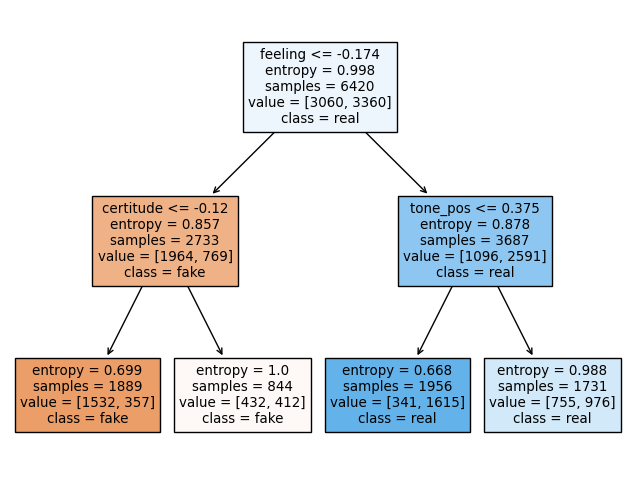

In [72]:
model.set_params(criterion='entropy', max_depth=2)
model.fit(dfs['train'].iloc[:, :-1], dfs['train'].iloc[:, -1],)

print(f"Training accuracy: {100 * accuracy_score(model.predict(dfs['train'].iloc[:, :-1]), dfs['train'].iloc[:, -1]):.3f}%")
print(f"Validation accuracy: {100 * accuracy_score(model.predict(dfs['val'].iloc[:, :-1]), dfs['val'].iloc[:, -1]):.3f}%")
print(f"Testing accuracy: {100 * accuracy_score(model.predict(dfs['test'].iloc[:, :-1]), dfs['test'].iloc[:, -1]):.3f}%\n")

print(export_text(model, feature_names=columns[:-1])) #, class_names=['fake', 'real']))

fig = plt.figure(figsize=(8, 6))
_ = plot_tree(model, feature_names=columns[:-1], class_names=['fake', 'real'], filled=True)

In [75]:
model = RandomForestClassifier(criterion='entropy')
param_grid = {
    'n_estimators': (50, 100, 150, 200,),
}

clf = grid_search(model=model, param_grid=param_grid)

100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Best parameters:
    n_estimators: 150

Training accuracy: 98.333%
Validation accuracy: 81.355%
Testing accuracy: 81.308%


In [74]:
model = XGBClassifier()
param_grid = {
    'booster': ('gbtree', 'gblinear',),
}

clf = grid_search(model=model, param_grid=param_grid)

100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Best parameters:
    booster: gbtree

Training accuracy: 92.539%
Validation accuracy: 80.981%
Testing accuracy: 81.729%


In [44]:
import numpy as np
import torch
from torch.utils.data import default_collate, TensorDataset, DataLoader
from torch.nn import Module, ModuleList, Linear, GELU, Dropout, BCELoss
from torch.optim import AdamW
from torchmetrics import Accuracy, F1Score

In [45]:
def normalize(X_train, *X_other, eps=1e-6):

    mean, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
    yield (X_train-mean) / (std+eps)
    
    for X in X_other:
        yield (X-mean) / (std+eps)

In [50]:
X_train, y_train = dfs['train'].iloc[:, :-1].values, dfs['train'].iloc[:, -1].values
X_val, y_val = dfs['val'].iloc[:, :-1].values, dfs['val'].iloc[:, -1].values
X_test, y_test = dfs['test'].iloc[:, :-1].values, dfs['test'].iloc[:, -1].values

X_train, X_val, X_test = normalize(X_train, X_val, X_test)

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))

train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=default_collate, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=default_collate, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=default_collate, shuffle=True)

In [51]:
class Model(Module):

    def __init__(self, input_shape=18, hidden_size=128, layers=4, dropout=0.1):

        super(Model, self).__init__()

        dense_layers = list()
        for in_features, out_features in zip([input_shape]+[hidden_size]*(layers-1), [hidden_size]*(layers-1)+[1]):
            dense_layer = Linear(in_features=in_features, out_features=out_features, bias=True)
            dense_layers.append(dense_layer)

        self.dense_layers = ModuleList(dense_layers)
        self.activation = GELU()
        self.dropout = Dropout(p=dropout, inplace=False)

        self.loss = BCELoss()

    def forward(self, x, y):

        for dense_layer in self.dense_layers[:-1]:
            x = dense_layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        
        logits = self.dense_layers[-1](x).squeeze(-1)
        probs = torch.sigmoid(logits)
        preds = torch.round(probs).detach().cpu()
        loss = self.loss(probs, y.float())

        return preds, loss
    
model = Model(input_shape=X_train.shape[-1], hidden_size=128, layers=4, dropout=0.2)
optimizer = AdamW(model.parameters(), lr=5e-4)

In [52]:
accuracy, f1_score = Accuracy(task='binary'), F1Score(task='binary')

for epoch in range(1, 101):

    model.train()
    epoch_labels, epoch_preds, epoch_losses = list(), list(), list()
    for features, labels in train_loader:
        optimizer.zero_grad()
        preds, loss = model(features, labels)
        loss.backward()
        optimizer.step()
        epoch_labels.append(labels.detach().cpu()); epoch_preds.append(preds); epoch_losses.append(loss.item())
    epoch_labels = torch.cat(epoch_labels); epoch_preds = torch.cat(epoch_preds); mean_loss = np.mean(epoch_losses)

    if epoch%10 == 0:
        print(f'Epoch {epoch}\nTraining: Accuracy = {100*accuracy(epoch_preds, epoch_labels).item():.4f}%, F1-Score = {100*f1_score(epoch_preds, epoch_labels).item():.4f}%, Loss = {mean_loss:.6f}')
        model.eval()
        epoch_labels, epoch_preds, epoch_losses = list(), list(), list()
        with torch.no_grad():
            for features, labels in val_loader:
                preds, loss = model(features, labels)
                epoch_labels.append(labels.detach().cpu()); epoch_preds.append(preds); epoch_losses.append(loss.item())
        epoch_labels = torch.cat(epoch_labels); epoch_preds = torch.cat(epoch_preds); mean_loss = np.mean(epoch_losses)
        print(f'Validation Accuracy = {100*accuracy(epoch_preds, epoch_labels).item():.4f}%, F1-Score = {100*f1_score(epoch_preds, epoch_labels).item():.4f}%, Loss = {mean_loss:.6f}')
        epoch_labels, epoch_preds, epoch_losses = list(), list(), list()
        with torch.no_grad():
            for features, labels in test_loader:
                preds, loss = model(features, labels)
                epoch_labels.append(labels.detach().cpu()); epoch_preds.append(preds); epoch_losses.append(loss.item())
        epoch_labels = torch.cat(epoch_labels); epoch_preds = torch.cat(epoch_preds); mean_loss = np.mean(epoch_losses)
        print(f'Testing Accuracy = {100*accuracy(epoch_preds, epoch_labels).item():.4f}%, F1-Score = {100*f1_score(epoch_preds, epoch_labels).item():.4f}%, Loss = {mean_loss:.6f}\n')

Epoch 10
Training: Accuracy = 78.2555%, F1-Score = 79.8208%, Loss = 0.455638
Validation Accuracy = 78.3645%, F1-Score = 79.7374%, Loss = 0.456037
Testing Accuracy = 78.0841%, F1-Score = 79.6529%, Loss = 0.466237

Epoch 20
Training: Accuracy = 80.0156%, F1-Score = 81.3923%, Loss = 0.433662
Validation Accuracy = 79.3925%, F1-Score = 80.8511%, Loss = 0.445436
Testing Accuracy = 79.7664%, F1-Score = 81.3442%, Loss = 0.455573

Epoch 30
Training: Accuracy = 80.7944%, F1-Score = 82.0811%, Loss = 0.414808
Validation Accuracy = 80.5607%, F1-Score = 82.0380%, Loss = 0.437543
Testing Accuracy = 79.6729%, F1-Score = 81.2903%, Loss = 0.450296

Epoch 40
Training: Accuracy = 81.9315%, F1-Score = 83.1542%, Loss = 0.398529
Validation Accuracy = 80.2804%, F1-Score = 81.7158%, Loss = 0.445489
Testing Accuracy = 79.9065%, F1-Score = 81.3853%, Loss = 0.452018

Epoch 50
Training: Accuracy = 82.7259%, F1-Score = 83.9763%, Loss = 0.382510
Validation Accuracy = 80.5140%, F1-Score = 81.7025%, Loss = 0.439197
Te